In [1]:
import tensorflow as tf
import glob
#import tensorflow_io as tfio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib
#matplotlib.use('Agg')

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
tf.__version__

'2.3.0'

In [4]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [6]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

(150, 230)


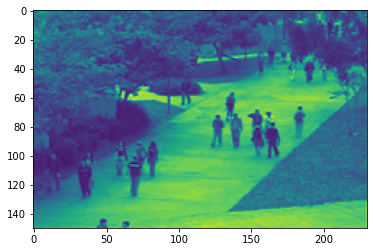

In [7]:
im = Image.open('UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001/002.tif')
im = im.resize((230,150))
print(np.array(im).shape)
plt.imshow(im)

In [8]:
# n = 10

# a = np.zeros((int(len(files)/n), n, 227, 227))
# i = 0
# idx = 0

# for filename in range(0, len(files)):
#     im = Image.open(files[filename])
#     im = im.resize((227,227))
#     a[idx,i,:,:] = np.array(im, dtype=np.float32)/255.0
#     i = i + 1
#     if i > 9:
#         idx = idx + 1
#         i = 0


In [9]:
IMG_HEIGHT=227
IMG_WIDTH=227
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE=16

train_set = 'UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*.tif'

train_files = sorted(glob.glob(train_set))

n = 10
a = np.zeros((int(len(train_files)/n),IMG_HEIGHT, IMG_WIDTH,n)).astype(np.float32)
i = 0
idx = 0

for filename in range(0, len(train_files)):
    im = Image.open(train_files[filename])
    im = im.resize((IMG_WIDTH, IMG_HEIGHT))
    a[idx,:,:,i] = np.array(im)/255.0
    i = i + 1
    if i > 9:
        idx = idx + 1
        i = 0
        
print(a.shape)

train_dataset  = tf.data.Dataset.from_tensor_slices((a, a)).shuffle(1000, 
                                                                    seed=42, 
                                                                    reshuffle_each_iteration=False).batch(BATCH_SIZE)
print(len(list(train_dataset)))

(680, 227, 227, 10)
43


In [10]:
test_set = 'UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'

test_files = sorted(glob.glob(test_set))

a = np.zeros((int(len(test_files)/n),IMG_WIDTH, IMG_HEIGHT,n)).astype(np.float32)
i = 0
idx = 0

for filename in range(0, len(test_files)):
    im = Image.open(test_files[filename])
    im = im.resize((IMG_WIDTH,IMG_HEIGHT))
    a[idx,:,:,i] = np.array(im, dtype=np.float32)/255.0
    i = i + 1
    if i > 9:
        idx = idx + 1
        i = 0
        
    
test_dataset = tf.data.Dataset.from_tensor_slices((a, a)).batch(1)
print(len(list(test_dataset)))

20


In [11]:
count = 0
for x,y in train_dataset.take(BATCH_SIZE):
    print(x.shape, y.shape)
    count = count + 1
    if count > 5:
        break

(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)


(16, 227, 227, 10)


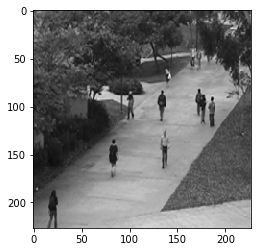

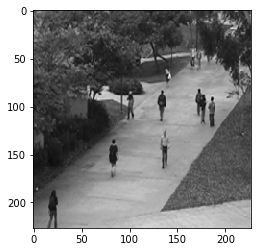

tf.Tensor(
[[0.40392157 0.40392157 0.34509805 ... 0.20784314 0.27058825 0.3137255 ]
 [0.33333334 0.34117648 0.32941177 ... 0.20784314 0.24705882 0.35686275]
 [0.29411766 0.30588236 0.32156864 ... 0.22745098 0.21176471 0.36862746]
 ...
 [0.46666667 0.47058824 0.4745098  ... 0.6745098  0.67058825 0.7529412 ]
 [0.4745098  0.48235294 0.4862745  ... 0.68235296 0.67058825 0.75686276]
 [0.4745098  0.4862745  0.49019608 ... 0.69411767 0.6745098  0.7647059 ]], shape=(227, 227), dtype=float32)


In [12]:
import matplotlib.pyplot as plt

for image,label in train_dataset.take(1):
    print(image.shape)
    img = image[0][:,:,0]
    lbl = label[0][:,:,0]
    plt.imshow(img,cmap=plt.cm.gray, interpolation='nearest')
    plt.show()
    plt.imshow(lbl,cmap=plt.cm.gray, interpolation=1'nearest')
    plt.show()
    print(img)

In [13]:
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

#with strategy.scope():
conv_encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH,n)),
                tf.keras.layers.Conv2D(512,kernel_size=15, strides=(4,4), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D(pool_size=2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(256, kernel_size=4,activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D(pool_size=2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(128, kernel_size=3,activation='relu'),
                tf.keras.layers.BatchNormalization()
            ]
        )

conv_decoder = tf.keras.Sequential(
            [   
                tf.keras.layers.Conv2DTranspose(256, kernel_size=3, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D(2, interpolation='nearest'),
                tf.keras.layers.Conv2DTranspose(512, kernel_size=4, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D(2, interpolation='nearest'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(10, kernel_size=15, strides=(4,4),activation="sigmoid")
            ]            
        )


In [14]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,10))
encoded = conv_encoder(image_input)
print(encoded.shape)
decoded = conv_decoder(encoded)
print(decoded.shape)

(None, 10, 10, 128)
(None, 227, 227, 10)


In [15]:
conv_ae = tf.keras.Model(inputs=image_input, outputs=decoded)

#conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4),
        metrics=['mae'])

In [16]:
#conv_ae(np.ones((1,100,100,1), dkaggletype=np.float32))

conv_ae.summary()




Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 10)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 10, 10, 128)       3551616   
_________________________________________________________________
sequential_1 (Sequential)    (None, 227, 227, 10)      3549962   
Total params: 7,101,578
Trainable params: 7,095,690
Non-trainable params: 5,888
_________________________________________________________________


In [17]:
history = conv_ae.fit(train_dataset, epochs=30, validation_data=test_dataset, callbacks=[tensorboard_cb])


Epoch 1/30
 1/43 [..............................] - ETA: 0s - loss: 0.0619 - mae: 0.2151WARNING:tensorflow:From /home/markk/anaconda3/envs/tf2env/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
43/43 [==============================] - 16s 374ms/step - loss: 0.0257 - mae: 0.1259 - val_loss: 0.0784 - val_mae: 0.2474
Epoch 2/30
43/43 [==============================] - 15s 351ms/step - loss: 0.0130 - mae: 0.0766 - val_loss: 0.0428 - val_mae: 0.1710
Epoch 3/30
43/43 [==============================] - 15s 350ms/step - loss: 0.0103 - mae: 0.0661 - val_loss: 0.0293 - val_mae: 0.1362
Epoch 4/30
43/43 [==============================] - 16s 361ms/step - loss: 0.0092 - mae: 0.0617 - val_loss: 0.0227 - val_mae: 0.1196
Epoch 5/30
43/43 [==============================] - 16s 363ms/step - loss: 0.0082 - mae: 0

In [18]:
conv_ae.save('convstae.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: convstae.model/assets


In [19]:
def plot_training_loss(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

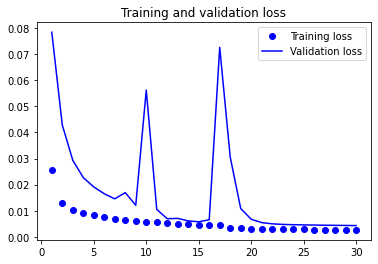

In [20]:
plot_training_loss(history)

In [21]:
def plot_image(image):
    print('plot image {}'.format(image.shape))
    plt.imshow(image[:,:,0], cmap=plt.cm.gray, interpolation='nearest')
    plt.axis("off")

In [22]:
def show_reconstructions(model, images, n_images=5):
    print('show reconstructions = {}'.format(images.shape))
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 3, 5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
test_images = list(test_dataset.take(3))
print(test_images)

show_reconstructions(conv_ae, test_images, n_images=1)

In [24]:
def plot(img, output, diff, H, threshold, counter):
    #print('inside plot, imgshape {}'.format(img.shape))
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    
    fig.savefig('images/{:0>3d}.png'.format(counter))

In [33]:
counter = 0

mse = tf.keras.losses.MeanSquaredError()

losses = []
for image, _ in test_dataset:
    counter = counter + 1
    output = conv_ae.predict(image)
    loss = mse(image, output)
    losses.append(loss)
    #print(f'loss of image {counter} = {loss}')

loss of image 1 = 0.0036105955950915813
loss of image 2 = 0.003563845995813608
loss of image 3 = 0.0036625268403440714
loss of image 4 = 0.003714639460667968
loss of image 5 = 0.004097794182598591
loss of image 6 = 0.004342596512287855
loss of image 7 = 0.0044650305062532425
loss of image 8 = 0.004774864763021469
loss of image 9 = 0.00500332098454237
loss of image 10 = 0.0048320097848773
loss of image 11 = 0.005001995246857405
loss of image 12 = 0.004873199388384819
loss of image 13 = 0.005124491639435291
loss of image 14 = 0.005664360709488392
loss of image 15 = 0.005583602003753185
loss of image 16 = 0.00565303722396493
loss of image 17 = 0.005199394654482603
loss of image 18 = 0.002486699027940631
loss of image 19 = 0.0024116954300552607
loss of image 20 = 0.002401006640866399


In [76]:
def plot_reconstruction_loss(img, losses, counter):
    fig = plt.figure()
    x = np.arange(1,21)
    y = np.zeros(20)
    # show original image
    fig.add_subplot(221)
    plt.title(' image 1')
    plt.set_cmap('gray')
    plt.imshow(img)

    fig.add_subplot(222)
    plt.ylim(0,0.05)
    plt.title('histogram ')
    plt.plot(x,y)
    plt.plot(losses)

    
    plt.show() 
    
    fig.savefig('images/{:0>3d}.png'.format(counter))
    

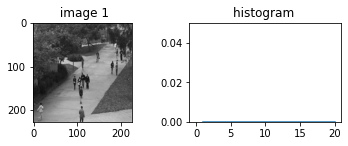

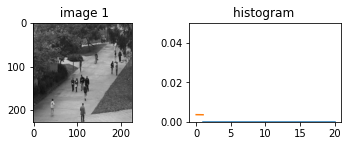

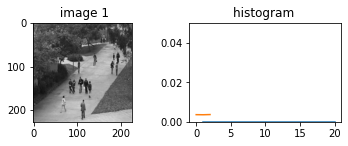

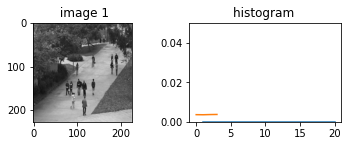

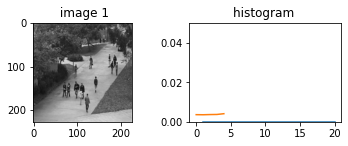

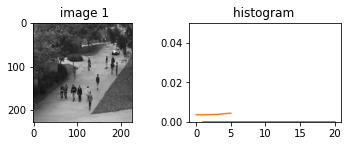

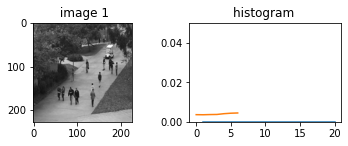

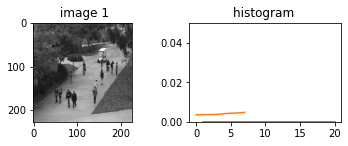

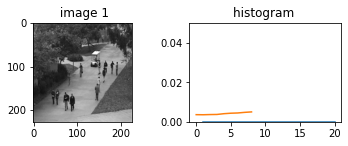

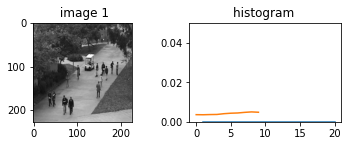

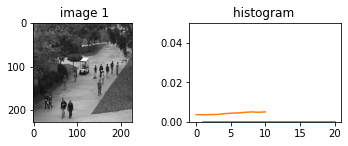

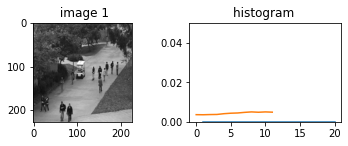

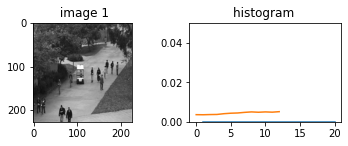

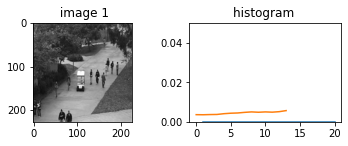

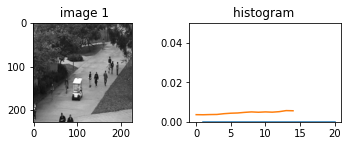

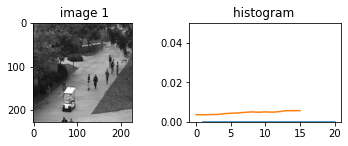

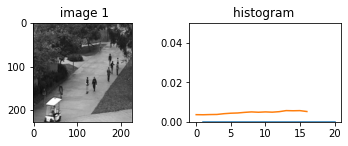

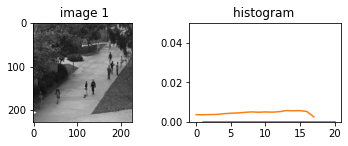

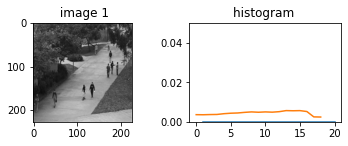

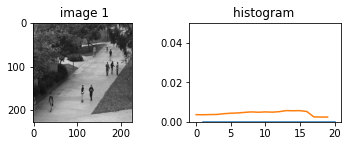

In [77]:
losses = []
counter = 0
for image, _  in test_dataset:
    counter = counter + 1
    output = conv_ae.predict(image)
    loss = mse(image, output)
    losses.append(loss)
    plot_reconstruction_loss(image[0,:,:,0], losses, counter)

In [71]:
print(losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0036105956>, <tf.Tensor: shape=(), dtype=float32, numpy=0.003563846>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0036625266>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0037146395>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0040977946>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0043425965>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0044650305>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0047748643>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0050033205>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00483201>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0050019952>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0048731994>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0051244916>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0056643607>, <tf.Tensor: shape=(), dtype=float32, numpy=0.005583602>, <tf.Tensor: shape=(), dtype=float32, numpy=0.005653037>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0051993947>, <tf.Tensor: shape=

image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227, 227, 10)
image shape = (1, 227, 227, 10)
reconstucted shape = (1, 227, 227, 10)
diff shape= (1, 227,

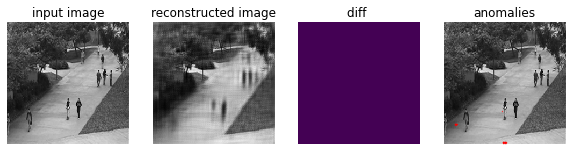

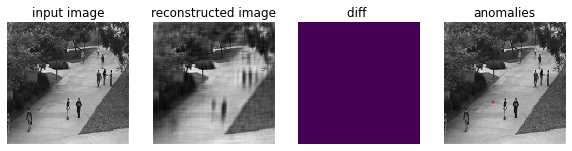

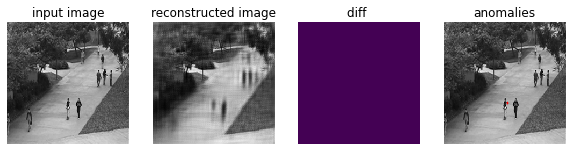

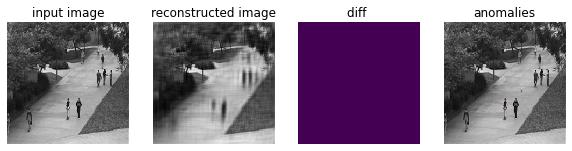

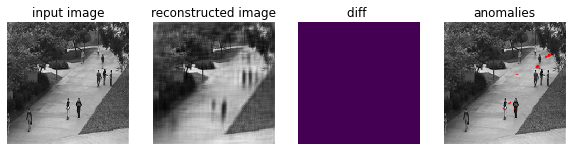

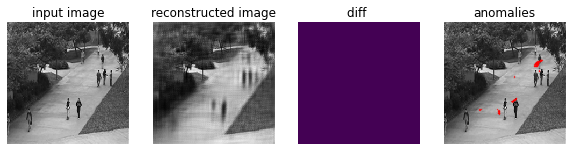

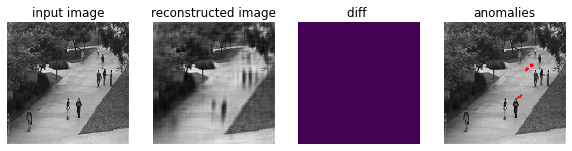

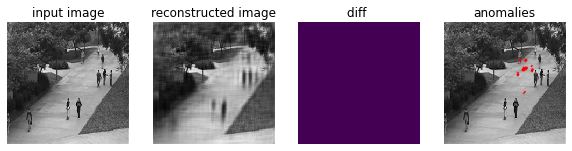

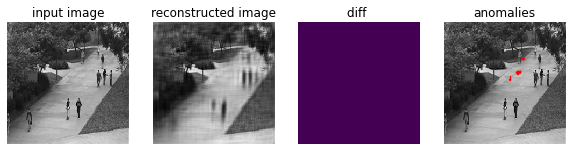

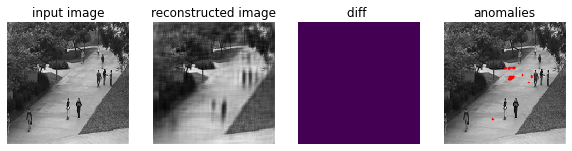

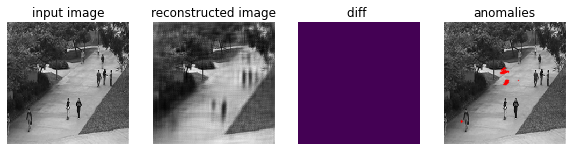

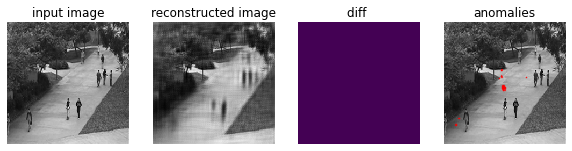

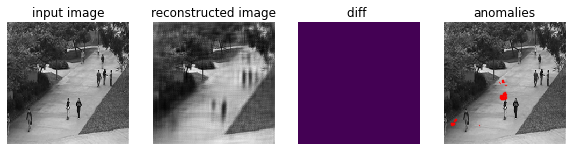

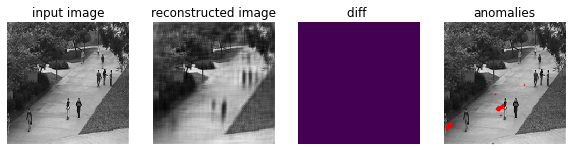

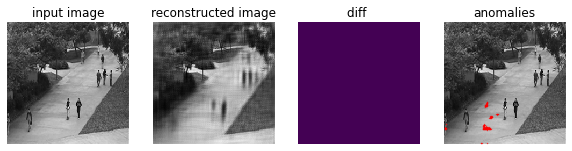

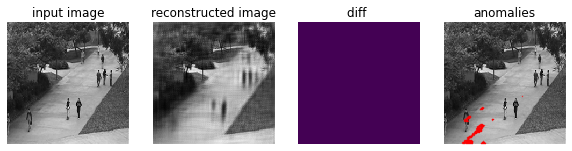

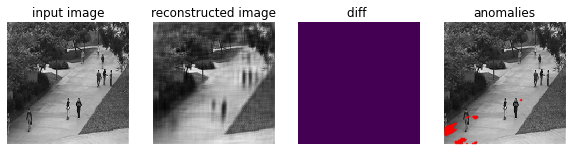

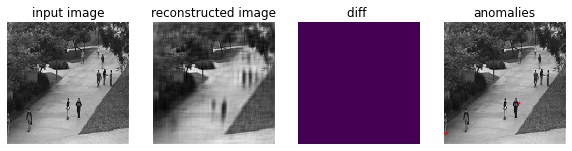

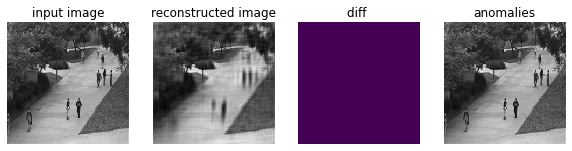

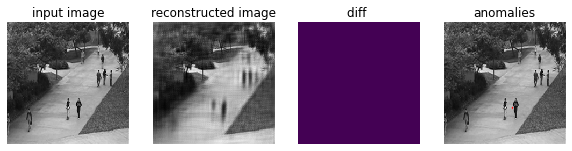

In [117]:
threshold = 7
counter = 0

for image, __ in test_dataset:
    print(f'image shape = {image.shape}')
    counter = counter + 1
    #image = tf.multiply(tf.cast(image, tf.float32), 255.)
    image = image.numpy()
    reconstructed = conv_ae.predict(image)
    #reconstructed = tf.multiply(reconstructed, 255.)
    #diff = tf.abs(tf.subtract(reconstructed,image))
    print(f'reconstucted shape = {reconstructed.shape}')
    diff = np.abs(reconstructed - image)
    print(f'diff shape= {diff.shape}')
    image = np.sum(image, axis=3, keepdims=True)
    reconstructed = np.sum(reconstructed, axis=3, keepdims=True)
    diff_max = np.max(diff, axis=3)
    diff_min = np.min(diff, axis=3)
    regularity = diff_max - diff_min
    #print(regularity.shape)
    # perform convolution on regularity matrix
    H = signal.convolve2d(regularity[0,:,:], np.ones((4,4)), mode='same')
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)

(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)
(1, 227, 227, 10)


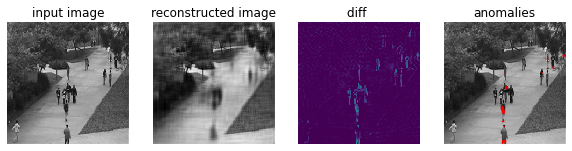

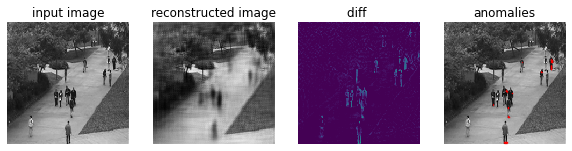

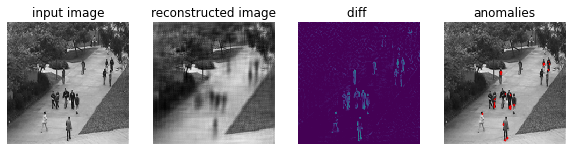

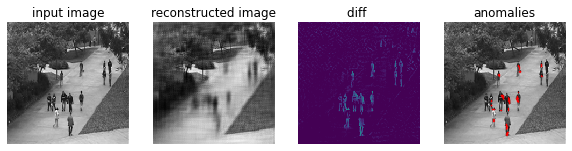

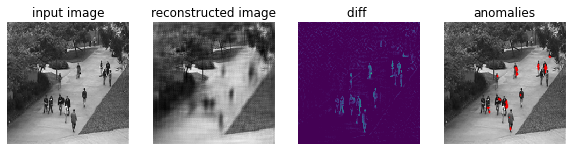

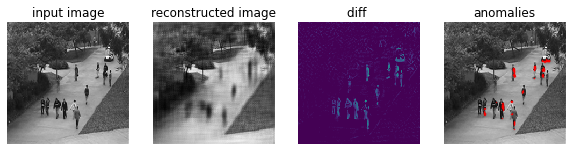

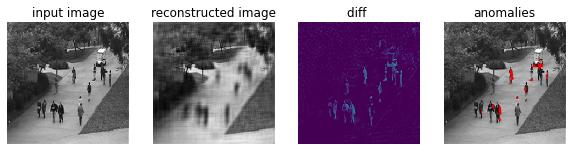

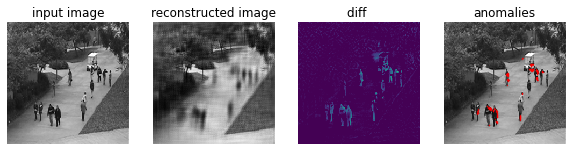

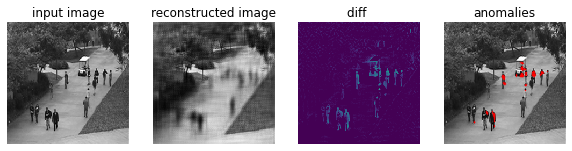

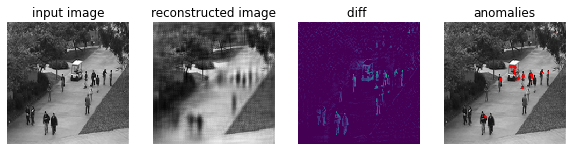

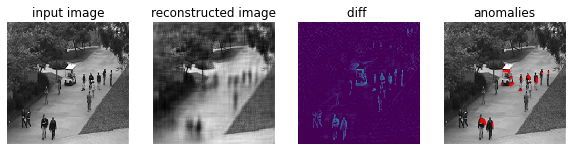

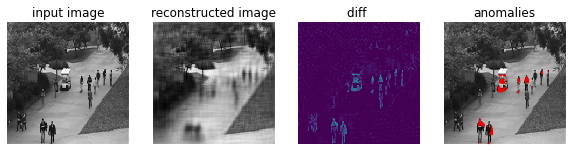

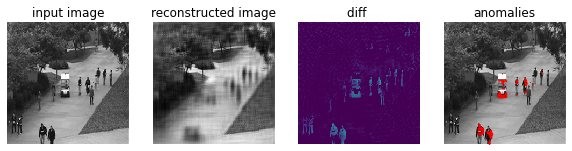

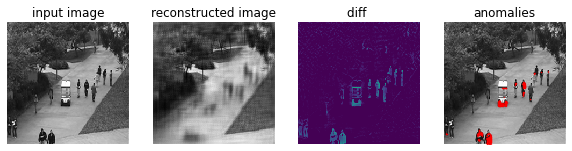

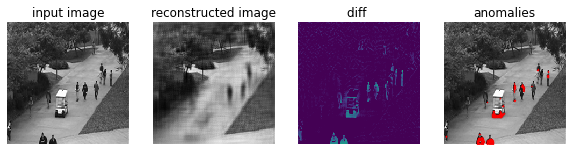

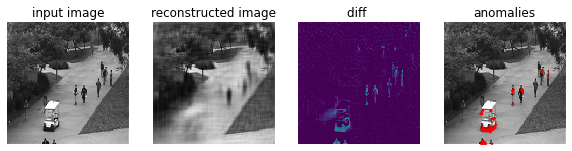

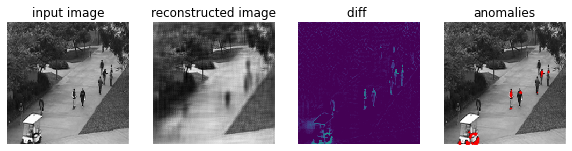

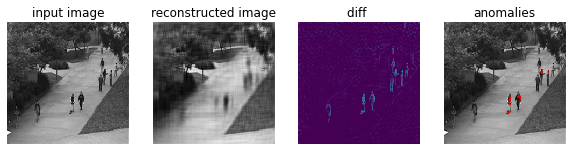

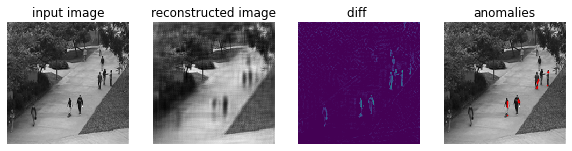

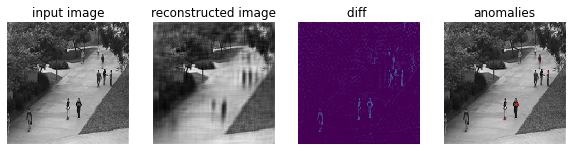

In [88]:
threshold = 4.*255
counter = 0

for image, _  in test_dataset:
    counter = counter + 1
    output = conv_ae.predict(image)
    output = tf.multiply(output,255.)
    img = tf.multiply(tf.cast(image, tf.float32), 255.)
    diff = tf.subtract(output,img)
    print(diff.shape)
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    

In [78]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = sorted(glob.glob('images/*.png'))
print(imgs[:10])
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('result.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

['images/001.png', 'images/002.png', 'images/003.png', 'images/004.png', 'images/005.png', 'images/006.png', 'images/007.png', 'images/008.png', 'images/009.png', 'images/010.png']
